In [1]:
using Flux, Statistics
using Flux.Data: DataLoader
using Flux: onehotbatch, onecold, @epochs
using Flux.Losses: logitcrossentropy
using Base: @kwdef
using MLDatasets
using Plots

In [2]:
include("network.jl")
include("vsa.jl")

similarity_outer (generic function with 1 method)

In [3]:
include("spiking.jl")

train_to_phase (generic function with 1 method)

In [4]:
model = Chain(PhasorDense(1024 => 32), )

Chain(
  PhasorDense(1024 => 32),              # 32_800 parameters
) 

In [5]:
x = random_symbols((100, 1024))

100×1024 Matrix{Float64}:
  0.700421   -0.493225     0.961857   …   0.0149306  -0.843417    0.0647154
  0.685528    0.246164    -0.0517484      0.567157    0.296729   -0.0402226
 -0.743449   -0.407597     0.0736445      0.1177      0.49437     0.0802615
  0.744683   -0.802286     0.377364      -0.377424   -0.238459    0.854245
  0.0424718  -0.130829    -0.800847      -0.893445   -0.935993    0.457778
  0.747399    0.947117     0.834441   …   0.361748    0.0901854   0.969872
  0.0113112   6.36578e-5   0.528145       0.135038   -0.348639   -0.465556
 -0.97323     0.0787477    0.703918      -0.971472   -0.656937    0.831897
  0.578598   -0.3952      -0.0260036     -0.664122    0.967194    0.185679
  0.0602371  -0.212288    -0.45501       -0.134682    0.619302   -0.279231
  0.632951   -0.658376     0.944326   …   0.86621     0.931792    0.256885
  0.656328   -0.518155     0.444474      -0.474472   -0.201528   -0.207927
 -0.686091    0.534309     0.113297       0.124834    0.972299    0.823

In [6]:
x |> size

(100, 1024)

In [7]:
y = model(x)

100×32 Matrix{Float64}:
  0.658309    -0.140823     0.183314    …  -0.0656038   -0.224332
 -0.0762902    0.184136     0.313495       -0.403248     0.147471
 -0.296373    -0.0938589   -0.0471615      -0.278703    -0.0763827
 -0.368903    -0.00574359   0.363656       -0.543319    -0.0711767
 -0.0861191    0.274925     0.146947       -0.172709    -0.292899
  0.0371384   -0.0525997   -0.232065    …  -0.527364    -0.203912
  0.0968765   -0.00998488   0.286017       -0.563106     0.353916
 -0.280659    -0.515922    -0.147849        0.574374    -0.678931
  0.496536    -0.608833    -0.188464        0.0542369    0.285245
 -0.00637246   0.121047    -0.115274        0.290424     0.00263875
  0.204297     0.535765     0.037158    …  -0.0341896    0.0143231
  0.487362    -0.00232596   0.384279        0.0128783   -0.248371
 -0.0903511    0.09736      0.0165263      -0.509191     0.00903986
  ⋮                                     ⋱   ⋮           
  0.33872     -0.0434072    0.354746       -0.0118408 

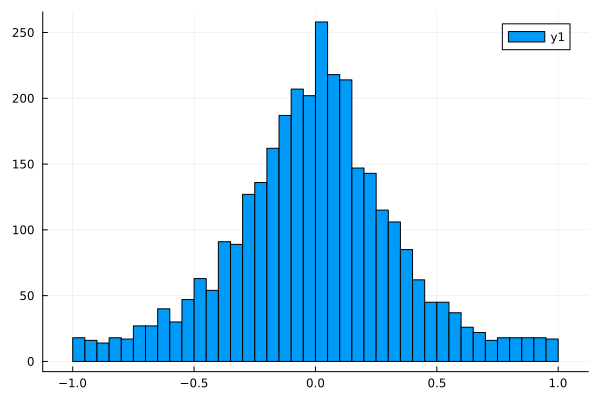

In [8]:
histogram(y |> vec)

In [9]:
function getdata(args)
    ENV["DATADEPS_ALWAYS_ACCEPT"] = "true"

    @info "Getting and transforming data"

    ## Load dataset
    xtrain, ytrain = MLDatasets.MNIST(:train)[:]
    xtest, ytest = MLDatasets.MNIST(:test)[:]

    ## Reshape input data to flatten each image into a linear array
    xtrain = Flux.flatten(xtrain)
    xtest = Flux.flatten(xtest)

    ## One-hot-encode the labels
    ytrain, ytest = onehotbatch(ytrain, 0:9), onehotbatch(ytest, 0:9)

    ## Create two DataLoader objects (mini-batch iterators)
    train_loader = DataLoader((xtrain, ytrain), batchsize=args.batchsize, shuffle=true)
    test_loader = DataLoader((xtest, ytest), batchsize=args.batchsize)

    return train_loader, test_loader
end

getdata (generic function with 1 method)

In [10]:
function build_model(; imgsize=(28,28,1), nclasses=10)
    return Chain( PhasorDense(prod(imgsize) => 32),
                  PhasorDense(32 => nclasses))
end

build_model (generic function with 1 method)

In [11]:
@kwdef mutable struct Args
    η::Float64 = 3e-4       ## learning rate
    batchsize::Int = 256    ## batch size
    epochs::Int = 10        ## number of epochs
    use_cuda::Bool = false   ## use gpu (if cuda available)
end

Args

In [12]:
train_loader, test_loader = getdata(Args())

[ Info: Getting and transforming data


(DataLoader(::Tuple{Matrix{Float32}, OneHotArrays.OneHotMatrix{UInt32, Vector{UInt32}}}, shuffle=true, batchsize=256), DataLoader(::Tuple{Matrix{Float32}, OneHotArrays.OneHotMatrix{UInt32, Vector{UInt32}}}, batchsize=256))

In [13]:
x, y = first(train_loader)

(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Bool[0 1 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 1 1])

In [14]:
x

784×256 Matrix{Float32}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [15]:
y

10×256 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  1  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  1  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 1  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  1  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1     ⋅  1  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  1

In [16]:
phasor_model = build_model()

Chain(
  PhasorDense(784 => 32),               # 25_120 parameters
  PhasorDense(32 => 10),                # 330 parameters
)                   # Total: 4 arrays, 25_450 parameters, 199.078 KiB.

In [17]:
pc = phasor_model(x')

256×10 Matrix{Float32}:
 -0.720626    0.105881     0.022819     …  -0.0926587   -0.000621407
 -0.826341    0.0553305   -0.0160855        0.20149     -0.943157
  0.967588    0.00872086  -0.0394045        0.0931511    0.494423
 -0.956161   -0.0218226    0.058848        -0.0168342   -0.378043
  0.984397    0.0166392    0.12119         -0.0215909    0.821742
  0.915949   -0.00765423  -0.0570069    …  -0.548417    -0.159851
 -0.444833    0.0317705    0.106491         0.445809     0.0559058
  0.123944    0.0181756   -0.0945829        0.369326    -0.0495754
 -0.988825    0.0526604    0.0715534        0.0899913   -0.83667
  0.866515    0.0611421   -0.00865048      -0.00119217  -0.599483
  0.896428   -0.0196738   -0.000783899  …  -0.189451     0.293137
 -0.79847     0.0594577   -0.0475555        0.00513392  -0.305997
 -0.90968     0.0941685   -0.0628944        0.179292    -0.185302
  ⋮                                     ⋱               
  0.923391    0.0133773    0.0261311        0.0590813   -

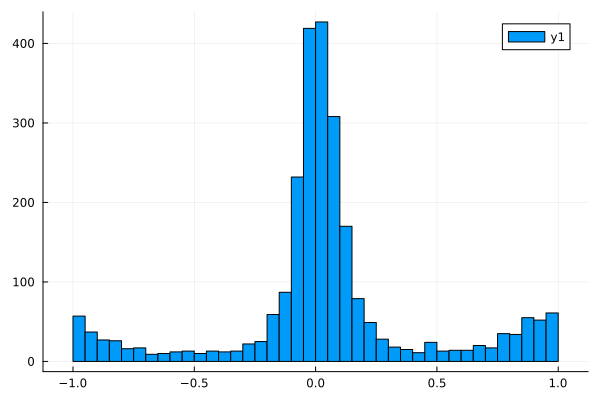

In [18]:
histogram(pc |> vec)

In [19]:
sa = default_spk_args()

SpikingArgs(6.283185307179586, -0.2, 1.0, 0.03, 0.05)

In [20]:
xt = phase_to_train(x', sa, 3, 0.0)

SpikeTrain(CartesianIndex{2}[CartesianIndex(1, 1), CartesianIndex(2, 1), CartesianIndex(3, 1), CartesianIndex(4, 1), CartesianIndex(5, 1), CartesianIndex(6, 1), CartesianIndex(7, 1), CartesianIndex(8, 1), CartesianIndex(9, 1), CartesianIndex(10, 1)  …  CartesianIndex(247, 784), CartesianIndex(248, 784), CartesianIndex(249, 784), CartesianIndex(250, 784), CartesianIndex(251, 784), CartesianIndex(252, 784), CartesianIndex(253, 784), CartesianIndex(254, 784), CartesianIndex(255, 784), CartesianIndex(256, 784)], [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5  …  2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5], (256, 784), 0.0)

In [21]:
xt.shape

(256, 784)

In [22]:
call = SpikingCall(xt, sa, (0.0, 10.0))

SpikingCall(SpikeTrain(CartesianIndex{2}[CartesianIndex(1, 1), CartesianIndex(2, 1), CartesianIndex(3, 1), CartesianIndex(4, 1), CartesianIndex(5, 1), CartesianIndex(6, 1), CartesianIndex(7, 1), CartesianIndex(8, 1), CartesianIndex(9, 1), CartesianIndex(10, 1)  …  CartesianIndex(247, 784), CartesianIndex(248, 784), CartesianIndex(249, 784), CartesianIndex(250, 784), CartesianIndex(251, 784), CartesianIndex(252, 784), CartesianIndex(253, 784), CartesianIndex(254, 784), CartesianIndex(255, 784), CartesianIndex(256, 784)], [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5  …  2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5], (256, 784), 0.0), SpikingArgs(6.283185307179586, -0.2, 1.0, 0.03, 0.05), (0.0, 10.0))

In [23]:
out1 = phasor_model[1](call)

SpikingCall(SpikeTrain(CartesianIndex{2}[CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(2, 1)  …  CartesianIndex(256, 32), CartesianIndex(256, 32), CartesianIndex(256, 32), CartesianIndex(256, 32), CartesianIndex(256, 32), CartesianIndex(256, 32), CartesianIndex(256, 32), CartesianIndex(256, 32), CartesianIndex(256, 32), CartesianIndex(256, 32)], [1.1900000000000008, 2.1899999999999973, 3.1999999999999758, 4.199999999999955, 5.209999999999933, 6.209999999999912, 7.2199999999998905, 8.21999999999987, 9.219999999999848, 2.199999999999997  …  0.7700000000000005, 1.8100000000000014, 2.8399999999999834, 3.899999999999961, 4.949999999999939, 5.029999999999937, 6.099999999999914, 7.149999999999892, 8.17999999999987, 9.189999999999849], (256, Base.OneTo(32)), 0.25), SpikingArgs(6.283185307179586, -0.2, 1.0, 0.03, 0.05), (0.0, 10.0

In [24]:
output = phasor_model(call)

SpikingCall(SpikeTrain(CartesianIndex{2}[CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(2, 1)  …  CartesianIndex(255, 10), CartesianIndex(255, 10), CartesianIndex(255, 10), CartesianIndex(256, 10), CartesianIndex(256, 10), CartesianIndex(256, 10), CartesianIndex(256, 10), CartesianIndex(256, 10), CartesianIndex(256, 10), CartesianIndex(256, 10)], [1.500000000000001, 2.479999999999991, 3.46999999999997, 4.459999999999949, 5.459999999999928, 6.459999999999907, 7.459999999999885, 8.459999999999864, 9.459999999999843, 2.569999999999989  …  7.539999999999884, 8.539999999999862, 9.529999999999841, 3.4999999999999694, 4.489999999999949, 5.419999999999929, 6.449999999999907, 7.449999999999886, 8.459999999999864, 9.469999999999843], (256, Base.OneTo(10)), 0.5), SpikingArgs(6.283185307179586, -0.2, 1.0, 0.03, 0.05), (0.0, 10.0))

In [25]:
ot = output.train

SpikeTrain(CartesianIndex{2}[CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(2, 1)  …  CartesianIndex(255, 10), CartesianIndex(255, 10), CartesianIndex(255, 10), CartesianIndex(256, 10), CartesianIndex(256, 10), CartesianIndex(256, 10), CartesianIndex(256, 10), CartesianIndex(256, 10), CartesianIndex(256, 10), CartesianIndex(256, 10)], [1.500000000000001, 2.479999999999991, 3.46999999999997, 4.459999999999949, 5.459999999999928, 6.459999999999907, 7.459999999999885, 8.459999999999864, 9.459999999999843, 2.569999999999989  …  7.539999999999884, 8.539999999999862, 9.529999999999841, 3.4999999999999694, 4.489999999999949, 5.419999999999929, 6.449999999999907, 7.449999999999886, 8.459999999999864, 9.469999999999843], (256, Base.OneTo(10)), 0.5)

In [26]:
length(ot.indices) / (256 * 10)

7.8046875

In [27]:
dx = train_to_phase(ot, output.spk_args)

10×256×10 Array{Float64, 3}:
[:, :, 1] =
 NaN     NaN     NaN     NaN     NaN     …  NaN     NaN     NaN     NaN
  -1.0   NaN       0.96    0.98   -0.98       0.96    0.94    0.96    0.84
   0.96   -0.86    0.96    1.0     0.96      -0.98    0.96    1.0     0.88
   0.94   -0.88    1.0    -0.98    0.9       -0.96    0.96   -0.92    0.98
   0.92   -0.88   -0.98    1.0     0.9       -0.94    0.96   -0.9     1.0
   0.92   -0.88    1.0     1.0     0.88  …   -0.96    0.94   -0.9    -0.96
   0.92   -0.9    -0.98    1.0     0.88      -0.94    0.94   -0.88   -0.94
   0.92   -0.86   -0.96    0.96    0.88      -0.92    0.94   -0.86   -0.88
   0.92   -0.8    -0.88    1.0     0.86      -0.9     0.94   -0.82   -0.78
   0.92   -0.74  NaN       1.0     0.84      -0.88    0.94   -0.8    -0.62

[:, :, 2] =
 NaN     NaN     NaN     NaN            …  NaN     NaN     NaN     NaN
 NaN     NaN      -0.04   -0.02            NaN     NaN     NaN     NaN
 NaN      -0.04   -0.06   -0.02            NaN       0.06 

In [29]:
dx[:,5,:]

10×10 Matrix{Float64}:
 NaN     NaN     NaN     NaN     NaN     …  NaN     NaN     NaN     NaN
  -0.98   -0.02    0.88   -0.96  NaN          0.96    0.92  NaN       0.92
   0.96   -0.08    0.88   -0.8   NaN          0.94    0.94   -0.1     0.92
   0.9    -0.04    0.88   -0.8    -0.04       0.98    0.96   -0.1     0.92
   0.9    -0.04    0.88   -0.8    -0.06       0.96    0.96   -0.1     0.92
   0.88   -0.04    0.88   -0.82   -0.04  …    0.96    0.96   -0.1     0.92
   0.88   -0.04    0.9    -0.82   -0.04       0.96    0.96   -0.1     0.92
   0.88   -0.02    0.9    -0.82   -0.04       0.96    0.96   -0.1     0.92
   0.86   -0.02    0.92   -0.84   -0.04       0.96    0.98   -0.1     0.92
   0.84   -0.02    0.92   -0.86   -0.02       0.96    0.98   -0.12    0.92

In [30]:
pc[5,:]

10-element Vector{Float32}:
  0.98439664
  0.016639156
  0.121190205
 -0.3010569
  0.05331239
 -0.08126456
 -0.025211532
  0.7594285
 -0.021590851
  0.8217416

In [31]:
function quadrature_loss(phases::AbstractMatrix, truth::AbstractMatrix)
    targets = 0.5 .* truth
    sim = similarity(phases, targets)
    return 1.0 .- sim
end


quadrature_loss (generic function with 1 method)

In [32]:
function accuracy_quadrature(phases::AbstractMatrix, truth::AbstractMatrix)
    predictions = getindex.(argmin(abs.(phases .- 0.5), dims=2), 2)
    labels = getindex.(findall(truth), 1)
    return predictions .== labels
end

accuracy_quadrature (generic function with 1 method)

In [33]:
mean(accuracy_quadrature(pc, y))

0.10546875

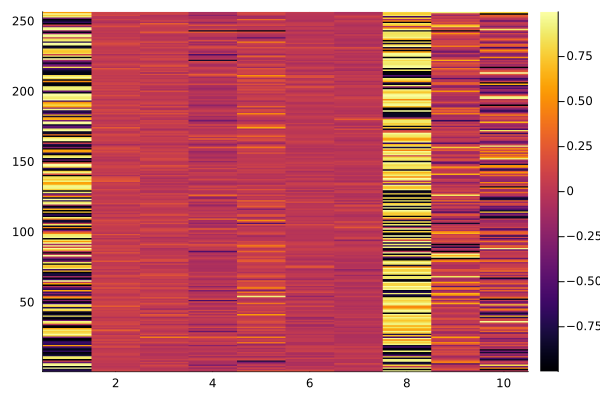

In [34]:
heatmap(pc)

In [35]:
function loss_and_accuracy(data_loader, model)
    acc = 0
    ls = 0.0f0
    num = 0
    for (x, y) in data_loader
        ŷ = model(x')
        
        ls += sum(quadrature_loss(ŷ, y'))
        acc += sum(accuracy_quadrature(ŷ, y)) ## Decode the output of the model
        num +=  size(x)[end]
    end
    return ls / num, acc / num
end

loss_and_accuracy (generic function with 1 method)

In [36]:
loss_and_accuracy(test_loader, phasor_model)

(0.49042260915770364, 0.0974)

In [37]:
using Zygote: withgradient

In [38]:
function train(model; kws...)
    args = Args(; kws...) ## Collect options in a struct for convenience

    # if CUDA.functional() && args.use_cuda
    #     @info "Training on CUDA GPU"
    #     CUDA.allowscalar(false)
    #     device = gpu
    # else
        @info "Training on CPU"
        device = cpu
    # end

    ## Create test and train dataloaders
    train_loader, test_loader = getdata(args)

    @info "Constructing model and starting training"
    ## Construct model
    #model = build_model() |> device

    ## Optimizer
    opt = Flux.setup(Adam(args.η), model)
    losses = []

    ## Training
    for epoch in 1:args.epochs
        for (x, y) in train_loader
            x, y = transpose(device(x)), transpose(device(y)) ## transfer data to device
            loss, gs = withgradient(m -> mean(quadrature_loss(m(x), y)), model) ## compute gradient of the loss
            append!(losses, loss)
            Flux.Optimise.update!(opt, model, gs[1]) ## update parameters
        end

        ## Report on train and test
        train_loss, train_acc = loss_and_accuracy(train_loader, model)
        test_loss, test_acc = loss_and_accuracy(test_loader, model)
        println("Epoch=$epoch")
        println("  train_loss = $train_loss, train_accuracy = $train_acc")
        println("  test_loss = $test_loss, test_accuracy = $test_acc")
    end

    return losses
end

train (generic function with 1 method)

In [39]:
opt = Flux.setup(Adam(3e-4), phasor_model)

(layers = ((weight = Leaf(Adam{Float64}(0.0003, (0.9, 0.999), 1.0e-8), (ComplexF32[0.0+0.0im 0.0+0.0im … 0.0+0.0im 0.0+0.0im; 0.0+0.0im 0.0+0.0im … 0.0+0.0im 0.0+0.0im; … ; 0.0+0.0im 0.0+0.0im … 0.0+0.0im 0.0+0.0im; 0.0+0.0im 0.0+0.0im … 0.0+0.0im 0.0+0.0im], ComplexF32[0.0+0.0im 0.0+0.0im … 0.0+0.0im 0.0+0.0im; 0.0+0.0im 0.0+0.0im … 0.0+0.0im 0.0+0.0im; … ; 0.0+0.0im 0.0+0.0im … 0.0+0.0im 0.0+0.0im; 0.0+0.0im 0.0+0.0im … 0.0+0.0im 0.0+0.0im], (0.9, 0.999))), bias = Leaf(Adam{Float64}(0.0003, (0.9, 0.999), 1.0e-8), (ComplexF32[0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im  …  0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im], ComplexF32[0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im  …  0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im], (0.9, 0.

In [41]:
l = train(phasor_model)

[ Info: Training on CPU
[ Info: Getting and transforming data
[ Info: Constructing model and starting training


Epoch=1
  train_loss = 0.05370351841581815, train_accuracy = 0.7645333333333333
  test_loss = 0.05332415259211547, test_accuracy = 0.772
Epoch=2
  train_loss = 0.03341595635666936, train_accuracy = 0.8673833333333333
  test_loss = 0.03285990877423033, test_accuracy = 0.874
Epoch=3
  train_loss = 0.02681314191134241, train_accuracy = 0.8961166666666667
  test_loss = 0.026206740699991446, test_accuracy = 0.8983
Epoch=4
  train_loss = 0.022891047387273645, train_accuracy = 0.91195
  test_loss = 0.022348635272235066, test_accuracy = 0.9132
Epoch=5
  train_loss = 0.021390541883842425, train_accuracy = 0.9195
  test_loss = 0.021111010128164884, test_accuracy = 0.9198
Epoch=6
  train_loss = 0.01914303508379811, train_accuracy = 0.92705
  test_loss = 0.019050882443851017, test_accuracy = 0.9258
Epoch=7
  train_loss = 0.018003123717075475, train_accuracy = 0.9317
  test_loss = 0.018018737250535644, test_accuracy = 0.9304
Epoch=8
  train_loss = 0.017001901695159752, train_accuracy = 0.9349
  tes

2350-element Vector{Any}:
 0.4931101519858148
 0.42804749978480655
 0.33638123646135754
 0.28594430702427476
 0.23625751181513777
 0.20819985162791138
 0.19247314022801598
 0.1762712829147206
 0.1640985780725156
 0.15812489462206794
 0.1495089505134113
 0.1530516620844485
 0.1441545894398884
 ⋮
 0.013886698157710573
 0.015143101841679725
 0.016984839473042933
 0.015959786201158323
 0.01845329203288694
 0.022307816778032955
 0.016527893846362076
 0.01739074872044835
 0.016338151920400338
 0.017834929619455115
 0.016298438752262064
 0.014528850106073918

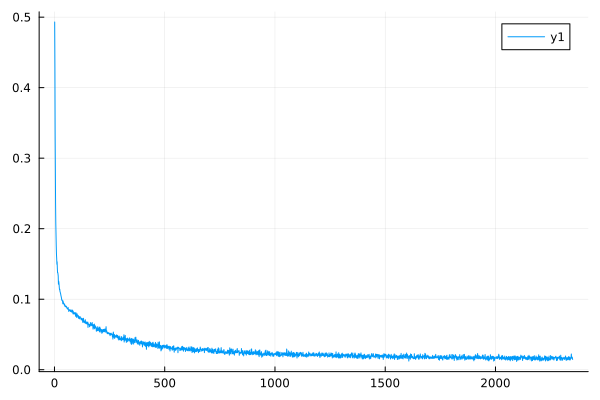

In [42]:
plot(l)

In [43]:
pc2 = phasor_model(x')

256×10 Matrix{Float32}:
 -0.0095085    -0.00612627    0.00530985   …   0.0864715    0.0112267
  0.323081     -0.00740181   -0.0558079        0.0513656    0.0628948
  0.146969     -0.00533426   -0.0364385        0.00663805   0.0429041
  0.0658735     0.00576744    0.00529554       0.00985077  -0.0211083
  0.00426789   -0.00499635    0.0245666        0.026672    -0.0121773
 -0.00151409   -0.000460755  -0.00469949   …   0.44057      0.0112918
  0.00243086    0.00801969    0.0604362       -0.0585575    0.0270399
 -0.0118906    -0.00199908    0.0067495       -0.0139446   -0.0467003
  0.0360839     0.0119823     0.0109211       -0.0235551   -0.0597763
 -0.000334426   0.0204245    -0.000829875     -0.00192704  -0.0135511
  0.023903     -0.0159323     0.498204     …  -0.0321004    0.0095614
  0.0790437     0.0058606     0.121264         0.0326599   -0.0221195
  0.0275687     0.0156798    -0.015685         0.397248     0.00443009
  ⋮                                        ⋱               
  0.0

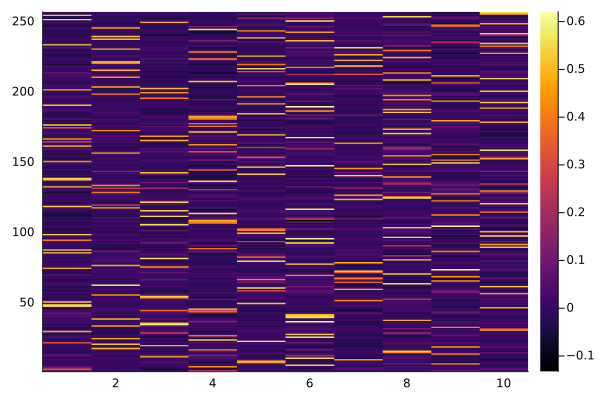

In [44]:
heatmap(pc2)

In [45]:
pc2 |> size

(256, 10)

In [46]:
pc2[1, :]

10-element Vector{Float32}:
 -0.009508498
 -0.006126274
  0.00530985
  0.29525828
 -0.0029707656
  0.0053956215
 -0.018702202
  0.017123858
  0.08647152
  0.011226694

In [47]:
y_spk = phasor_model(call)

SpikingCall(SpikeTrain(CartesianIndex{2}[CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(1, 1), CartesianIndex(2, 1), CartesianIndex(2, 1)  …  CartesianIndex(255, 10), CartesianIndex(256, 10), CartesianIndex(256, 10), CartesianIndex(256, 10), CartesianIndex(256, 10), CartesianIndex(256, 10), CartesianIndex(256, 10), CartesianIndex(256, 10), CartesianIndex(256, 10), CartesianIndex(256, 10)], [2.010000000000001, 2.99999999999998, 3.9999999999999587, 4.999999999999938, 5.9999999999999165, 7.009999999999895, 8.019999999999873, 9.009999999999852, 2.7499999999999853, 3.759999999999964  …  6.429999999999907, 1.480000000000001, 2.4599999999999915, 3.46999999999997, 4.469999999999949, 5.459999999999928, 6.439999999999907, 7.459999999999885, 8.479999999999864, 9.479999999999842], (256, Base.OneTo(10)), 0.5), SpikingArgs(6.283185307179586, -0.2, 1.0, 0.03, 0.05), (0.0, 10.0))

In [53]:
y_spk.train.offset

0.5

In [48]:
yp = train_to_phase(y_spk.train, y_spk.spk_args)

10×256×10 Array{Float64, 3}:
[:, :, 1] =
 NaN            NaN     NaN     NaN     …  NaN     NaN     NaN     NaN
 NaN            NaN      -0.14  NaN         -0.18    0.98   -0.1    -0.14
  -3.9968e-14    -0.5    -0.16  NaN         -0.14   -0.94   -0.08   -0.1
  -8.26006e-14   -0.48   -0.16    0.12      -0.12   -0.96   -0.1    -0.08
  -1.24345e-13   -0.48   -0.18    0.08      -0.12   -0.96   -0.1    -0.08
  -1.66978e-13   -0.48   -0.18    0.08  …   -0.14   -0.98   -0.1    -0.06
 NaN             -0.46   -0.18    0.06      -0.14    1.0    -0.1    -0.08
   0.02          -0.42   -0.18    0.08      -0.16    0.92   -0.1    -0.1
   0.04          -0.4    -0.18    0.06      -0.2     0.84   -0.12   -0.1
   0.02          -0.38   -0.14   -0.04      -0.22    0.72   -0.14   -0.1

[:, :, 2] =
 NaN     NaN     NaN           NaN     …  NaN     NaN     NaN     NaN
 NaN     NaN     NaN           NaN        NaN     NaN      -0.02  NaN
   0.06    0.06   -3.9968e-14  NaN         -0.86    0.06  NaN       0.04


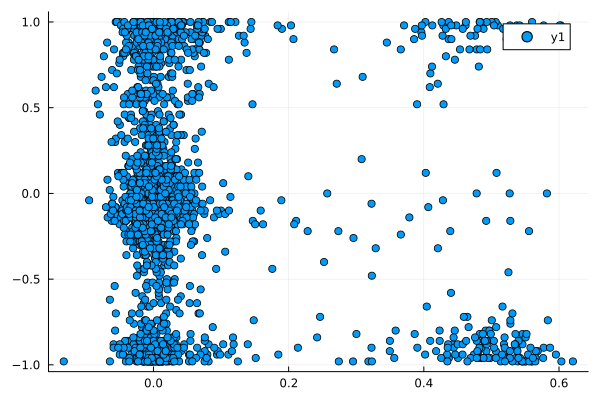

In [57]:
scatter(vec(pc2), vec(yp[4,:,:]))

In [52]:
yp[4,1,:]

10-element Vector{Float64}:
 -8.260059303211165e-14
  0.05999999999995875
  0.8799999999999413
 -0.9800000000000617
 -0.0800000000000809
  0.93999999999994
 -0.18000000000007876
 -0.10000000000008047
  0.9999999999999387
 -0.20000000000007834

In [45]:
y[:,1]

10-element OneHotVector(::UInt32) with eltype Bool:
 ⋅
 ⋅
 1
 ⋅
 ⋅
 ⋅
 ⋅
 ⋅
 ⋅
 ⋅

In [50]:
loss_and_accuracy(test_loader, phasor_model)

(0.016165774741772377, 0.9373)